# ARES
The Accelerated Reionization Era Simulations ([`ARES`](https://ares.readthedocs.io/en/latest/index.html)) code was designed to rapidly generate models for the global 21-cm signal.

Based on [Muñoz et al., 2015](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.92.083528), we added `ares/physics/DarkMatterHeating.py` to the original ARES to discuss the heating of baryons due to scattering with dark matter during the dark ages.

Following is a documentation about using `fit_param.py` to fit dark matter mass, `m_chi`, and the R.M.S. of streaming velocity, `V_rms`, between dark matter and gas, given 21-cm temperature signals, `dTb`, and the correponding redshifts, `z`.

Be warned: this code is still under active development – use at your own risk! Correctness of results is not guaranteed.

## Citation
If you use this code in paper please reference [TBD]() if it’s an application of fitting dark matter mass and R.M.S. of streaming velocity.

## Dependencies
You will need:
- numpy
- scipy
- matplotlib
- h5py
## Getting started
To clone a copy and install:
```
git clone https://github.com/Xsmos/ares.git
cd ares
python setup.py install
```
`ares` will look in `ares/input` for lookup tables of various kinds. To download said lookup tables, run
```
python remote.py
```
Check out the original [**ares**](https://ares.readthedocs.io/en/latest/install.html) for more details about installing the lookup tables.

## Parameters:
- `z_sample`: a 1-D array of redshifts.
- `dTb_sample`: a 2-D array of brightness temperatures in unit of `mK`. `dTb_sample.shape[1]` must be equal to `z_sample.shape[0]`.
- `param_guess`: the initial guess for the parameters `[m_chi, V_rms]` in units of `GeV` and `m/s`, respectively. Default is `[0.1, 29000]`.
- `cores`: number of CPUs to calculate the `dTb`s for different initial streaming velocites. Default is 1.
- `average_dir`: name of the directory to save the averaged dTb's. Default is `'dTb_averaged'`.
- `save_name`: name of the file to save the fitting results. Default is `'m_chi-V_rms.npy'`.
- `N_v_streams`: number of initial streaming velocities to be generated equally-spaced between `[0, 3*V_rms]` in order to calculate the averaged global `dTb`. Default is 12.
- `verbose`: 0 for showing the final fitting results only, 1 for including intermediate results of the fitting process.

## Example:

In [1]:
import numpy as np
from fit_param import interp_dTb, fit_param

cores = 24 # number of CPU
N_v_streams = cores

# assumptions about the dark matter mass and rms stream velocity
m_chi_true = 0.2 # GeV
V_rms_true = 35000 # m/s

z_sample = np.logspace(0, 3, 100) # redshifts corresponding to these observations

noise = 1 # mK. std of the signal noise, assumed to be Gaussian and frequency-independent

# sampling
N_observations = 50 # number of observations
dTb_accurate = interp_dTb(param=[m_chi_true, V_rms_true], z=z_sample, cores=cores, N_v_streams=N_v_streams, verbose=1)
dTb_sample = dTb_accurate + noise * np.random.normal(size=(N_observations, z_sample.shape[0]))

# fitting
fit_result = fit_param(z_sample, dTb_sample, cores=cores, N_v_streams=N_v_streams, save_name=f"m_chi{m_chi_true}-V_rms{V_rms_true}-.npy", verbose=0)

24 v_streams will be generated for m_chi = 0.2 GeV and V_rms = 35000 m/s...
Sampling 24 dTb's by 24 CPUs parallelly...
It costs 0:00:19.554383 to calculate dTb of 24 different initial_v_streams by 24 CPUs.
---------------------------------------------
Fitting starts...
#1 , fit: [2.07083799e-01 3.47149618e+04] , success: True , status: 3 , cost 0:06:00.919568
#2 , fit: [2.09126604e-01 3.45066825e+04] , success: True , status: 3 , cost 0:05:45.757399
#3 , fit: [2.10960453e-01 3.44715031e+04] , success: True , status: 3 , cost 0:05:36.308962
#4 , fit: [1.89178235e-01 3.54385886e+04] , success: True , status: 3 , cost 0:05:56.926076
#5 , fit: [2.25716151e-01 3.41909029e+04] , success: True , status: 3 , cost 0:05:56.674118
#6 , fit: [1.59560455e-01 3.68952524e+04] , success: True , status: 3 , cost 0:04:25.574639
#7 , fit: [1.85504822e-01 3.56610400e+04] , success: True , status: 3 , cost 0:05:16.457411
#8 , fit: [1.97176317e-01 3.49650061e+04] , success: True , status: 3 , cost 0:05:08.5

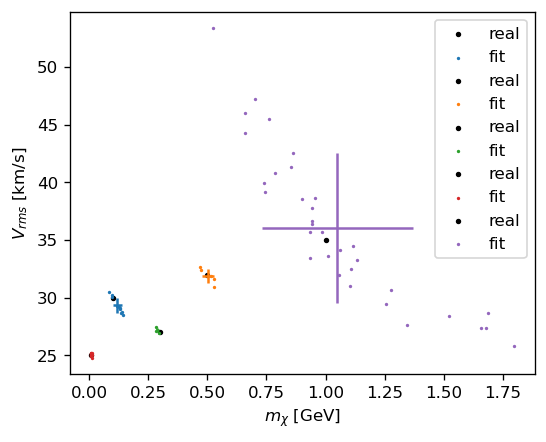

In [ ]:
import os
import matplotlib.pyplot as plt

fig = plt.figure(dpi=120, figsize=(5,4))
for filename in os.listdir():
    # one assumes all .npy file in current directory have m_chi*V_rms*.npy format.
    if ".npy" in filename:
        real_value = filename.split(sep="-")
        fit_data = np.load(filename)
        fit_mean = np.mean(fit_data, axis=0)
        plt.scatter(float(real_value[0][5:]), float(real_value[1][5:])/1000, c='k', label="real", s=5)
        plt.scatter(fit_data[:,0], fit_data[:,1]/1000, label="fit", s=1)
        plt.errorbar(fit_mean[0], fit_mean[1]/1000, xerr=np.std(fit_data[:,0]), yerr=np.std(fit_data[:,1])/1000)
        plt.xlabel(r"$m_{\chi}$ [GeV]")
        plt.ylabel(r"$V_{rms}$ [km/s]")
        plt.legend()
        plt.show()

In [ ]:
fig = plt.figure(dpi=120, figsize=(5,4))
dTb_fit = interp_dTb(param=fit_mean, z=z_sample, cores=cores, N_v_streams=N_v_streams, verbose=1)
plt.plot(z_sample, dTb_accurate, label='real')
plt.plot(z_sample, dTb_fit, label='fit')
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('dTb [mK]')
plt.xlim(0,300)
plt.legend()
plt.show()